In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading data and spliting

In [3]:
import re
def clean_bad_chars(x):
  x = re.sub(r"[^0-9a-zA-Z(!?.)']+", " ", x).strip()
  x = ''.join(" "+i+" " if i in ['!', '?', '.'] else i for i in x).strip()
  return x
def uncover_reduction(x):
  x = re.sub(r"i'm", "i am", x)
  x = re.sub(r"he's", "he is", x)
  x = re.sub(r"she's", "she is", x)
  x = re.sub(r"it's", "it is", x)
  x = re.sub(r"that's", "that is", x)
  x = re.sub(r"what's", "that is", x)
  x = re.sub(r"where's", "where is", x)
  x = re.sub(r"how's", "how is", x)
  x = re.sub(r"\'ll", " will", x)
  x = re.sub(r"\'ve", " have", x)
  x = re.sub(r"\'re", " are", x)
  x = re.sub(r"\'d", " would", x)
  x = re.sub(r"\'re", " are", x)
  x = re.sub(r"won't", "will not", x)
  x = re.sub(r"can't", "cannot", x)
  x = re.sub(r"n't", " not", x)
  x = re.sub(r"n'", "ng", x)
  x = re.sub(r"'bout", "about", x)
  x = re.sub(r"'til", "until", x)
  x = ' '.join(i.replace("'",'') for i in x.split(' ') if i ).strip()
  return x

In [4]:
data_path = '../processed_data'
mode = 'custom'
if mode=='w2v':
    with open(os.path.join(data_path,'w2v_embeddings.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='glove':
    with open(os.path.join(data_path,'glove_embeddings.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='custom':
    with open(os.path.join(data_path,'glove_embeddings_trained.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_trained.npy'), 'rb') as f:
        missing = np.load(f)
        
with open(os.path.join(data_path,'token_mapping.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [5]:
missing_idx = [token_mapping[i] for i in missing]

In [6]:
len(data)

82957

In [7]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [8]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [9]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'Cameron .'],
 ['Cameron .',
  'the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .'],
 ['the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .',
  'seems like she could get a date easy enough .']]

In [10]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [11]:
X, y = slice_data(data)

In [12]:
len(X), len(y)

(221068, 221068)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [14]:
len(X_train), len(X_test)

(187907, 33161)

In [16]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  return sent_ids


In [17]:
max_len_tokens = 20

In [18]:
X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
y_train = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_train])
y_test = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_test])


In [19]:
X_train_dec[0], y_train[0]

(array([    1, 21235,     7, 29898,     7, 29945,     7,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]),
 array([21235,     7, 29898,     7, 29945,     7,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]))

# Building a model 

In [20]:
emb_units = 100
lstm_units = 256
attention_units = 128
pretrained_embs = True
fine_tune = False

In [21]:
class PartialEmbeddingsUpdate(tf.keras.layers.Layer):
    def __init__(self, input_dim, 
                 output_dim, 
                indices_to_update,
                initializer='glorot_uniform',
                 **kwargs):
        super(PartialEmbeddingsUpdate, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.initializer = initializer
        self.indices_to_update = indices_to_update
       
    def build(self, input_shape):
        self.embeddings = self.add_weight(shape=(self.input_dim, self.output_dim),
                                             initializer=self.initializer,
                                            trainable=True)
        self.bool_mask = tf.equal(tf.expand_dims(tf.range(0,self.input_dim),1), tf.expand_dims(self.indices_to_update,0))
        self.bool_mask = tf.reduce_any(self.bool_mask,1)
        self.bool_mask_not = tf.logical_not(self.bool_mask)
        self.bool_mask_not = tf.expand_dims(tf.cast(self.bool_mask_not, dtype=self.embeddings.dtype),1)
        self.bool_mask = tf.expand_dims(tf.cast(self.bool_mask, dtype=self.embeddings.dtype),1)
        
    def call(self, input):
        input = tf.cast(input, dtype=tf.int32)
        embeddings = tf.stop_gradient(self.bool_mask_not * self.embeddings) + self.bool_mask * self.embeddings
        return tf.gather(embeddings,input)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'input_dim' : self.input_dim,
            'output_dim' : self.output_dim,
            'indices_to_update' : self.indices_to_update,
            'initializer' : self.initializer
        })
        return config

In [22]:
missing_indx = tf.constant(missing_idx, dtype=tf.float32)

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units,**kwargs):
    super(BahdanauAttention, self).__init__(**kwargs)
    self.units = units
    self.W1 = tf.keras.layers.Dense(self.units)
    self.W2 = tf.keras.layers.Dense(self.units)
    self.V = tf.keras.layers.Dense(1)


  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

  def get_config(self):

        config = super().get_config().copy()
        config.update({
            'units' : self.units,
        })
        return config

In [24]:
#encoder
enc_input = tf.keras.Input(shape=(None,), name='enc_input')
#shared embedding layer
if not pretrained_embs:
    utter_embedding = tf.keras.layers.Embedding(len(token_mapping), emb_units, name='embedding')
else:
    emb_units = final_embeddings.shape[1]
    if fine_tune:
        utter_embedding = tf.keras.layers.Embedding(len(token_mapping), emb_units, weights=[final_embeddings],
                                  name='embedding')
    else:
        utter_embedding = PartialEmbeddingsUpdate(len(token_mapping),emb_units, missing_idx, weights=[final_embeddings],
                                             name='embeddings')
    
embedded_enc = utter_embedding(enc_input)

encoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, name='encoder',
                               dropout=0.3
                               )
encoder_hidden_states, state_h, state_c  = encoder(embedded_enc)

#building encoder model
encoder = tf.keras.Model(enc_input, [encoder_hidden_states, state_h, state_c])
#decoder
dec_input = tf.keras.Input(shape=(None,), name='dec_input')
dec_state_input_h = tf.keras.Input(shape=(lstm_units,), name='state_h')
dec_state_input_c = tf.keras.Input(shape=(lstm_units,), name='state_c')
encoder_hidden_states = tf.keras.Input(shape=(None,lstm_units), name='enc_hidden_states')
#applying attention
attention = BahdanauAttention(attention_units)
context_vector, attention_weights = attention(dec_state_input_h,encoder_hidden_states)
embedded_dec = utter_embedding(dec_input)
inp = tf.concat([tf.expand_dims(context_vector, 1), embedded_dec], axis=-1)
decoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, name='decoder',
                              dropout=0.3)                               
#giving everything to output layer
decoder_hidden_states,  next_state_h, next_state_c  = decoder(inp,initial_state=[dec_state_input_h, dec_state_input_c])
decoder_hidden_states = tf.reshape(decoder_hidden_states, (-1, decoder_hidden_states.shape[2]))
output_layer = tf.keras.layers.Dense(len(token_mapping), activation=None, name='dense_logits')
result = output_layer(decoder_hidden_states)
decoder = tf.keras.Model([dec_input, dec_state_input_h, dec_state_input_c, encoder_hidden_states],
                         [result, next_state_h, next_state_c, attention_weights])


In [25]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
embeddings (PartialEmbedding (None, None, 100)         3000300   
_________________________________________________________________
encoder (LSTM)               [(None, None, 256), (None 365568    
Total params: 3,365,868
Trainable params: 3,365,868
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_h (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
enc_hidden_states (InputLayer)  [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
bahdanau_attention (BahdanauAtt ((None, 256), (None, 65921       state_h[0][0]                    
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, None)]       0                                            
____________________________________________________________________________________________

decoder


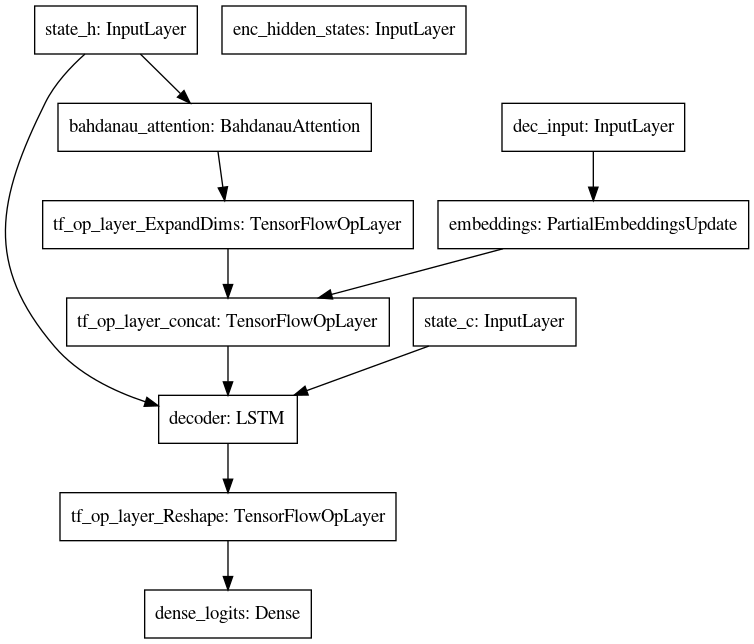

In [27]:
from tensorflow.keras.utils import plot_model
print('decoder')
plot_model(decoder)


encoder


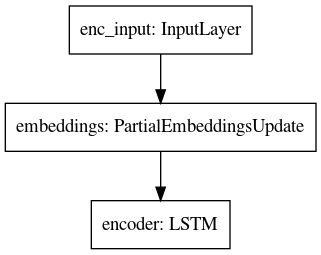

In [28]:
print('encoder')
plot_model(encoder)

# Some helpful stuff

In [29]:
def decode_sequence(x, greedy=False, top_k=50, len_output=50, 
                   return_attention=False, temperature=1):
    encoder_hidden_states, state_h, state_c = encoder(np.expand_dims(x,axis=0))
    attention_plot = []

    start = token_mapping[start_token]
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = token_mapping[start_token]


    stop_condition = False
    decoded_sentence = ''
    res=[]
    while True:
        # Sample a token
          output, state_h, state_c, attention_weights = decoder([target_seq, 
                                                                        state_h, 
                                                                        state_c,
                                                                        encoder_hidden_states])
          attention_weights = tf.reshape(attention_weights, (-1, ))
          attention_plot.append(attention_weights.numpy())
          output = np.hstack(output)/temperature  
          output = tf.nn.softmax(output).numpy()
          if greedy:
            sampled_token_index = np.argmax(output)
          else:  
            args = np.argsort(-output)[:top_k]
            probs = output[args]
            probs = tf.nn.softmax(probs).numpy()
            sampled_token_index = np.random.choice(args, size=1, p=probs)[0]

          if len(res) > len_output or sampled_token_index==token_mapping[end_token]:
              break
                
          res.append(sampled_token_index)

          target_seq = np.zeros((1, 1))
          target_seq[0, 0] = sampled_token_index
    
    attention_plot  = np.array(attention_plot)
    if return_attention:
        return res, attention_plot
    else:
        return res

In [30]:
def beam_search_predictions(x, beam_size = 3):
    start = [token_mapping[start_token]]
    encoder_hidden_states, state_h, state_c = encoder(np.expand_dims(x,axis=0))
    
    start_word = [[start, 0.0, state_h, state_c]]
    
    
    while len(start_word[0][0]) < max_len_tokens:
        temp = []
        for s in start_word:
            target_seq = np.array([[s[0][-1]]])
            state_h = s[2]
            state_c = s[3]
            output, state_h, state_c, attention_weights = decoder([target_seq, 
                                                                        state_h, 
                                                                        state_c,
                                                                        encoder_hidden_states])
            output = np.hstack(output)
            output = tf.nn.softmax(output).numpy()
            word_preds = np.argsort(output)[-beam_size:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += output[w]
                temp.append([next_cap, prob, state_h, state_c,])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_size:]
    
    start_word = start_word[-1][0]

    final_caption = []
    
    for i in start_word:
        if i != token_mapping[end_token]:
            final_caption.append(i)
        else:
            break    
    return final_caption[1:]

In [31]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [32]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [33]:
def give_answer(sentence, pad_unk=True, process_sentence=True, greedy=False,
               beam_search=False, beam_size=2, top_k=15, temperature=1, len_output=50, 
               show_attention=False):
  if process_sentence:
    cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
    unk_token = pad_token if pad_unk else "<unk>"
    processed_sentence = process(cleaned_sentence, unk_token)
    mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
  else:
    mapped_sentence = sentence
  if not beam_search:
      prediction = decode_sequence(mapped_sentence,greedy,top_k,len_output, return_attention=show_attention, 
                                  temperature=temperature)
      if show_attention:
        prediction, attention = prediction
  else:
      prediction = beam_search_predictions(mapped_sentence, beam_size)
  answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
  if show_attention:
        plot_attention(attention,sentence.split(' '), answer.split(' '))
  return answer
  

In [34]:
res = decode_sequence(X_test_enc[13], False, len_output=15)
res

[18469,
 1224,
 12459,
 16284,
 23308,
 18289,
 21497,
 23590,
 20117,
 22240,
 23590,
 13189,
 16489,
 131,
 28816,
 28163]

In [35]:
res = beam_search_predictions(X_test_enc[13], 7)
res

[14578,
 14578,
 23827,
 12459,
 12459,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 23144,
 6287]

# Training

In [57]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                           from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, token_mapping[pad_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [59]:
@tf.function
def evaluate(encoder_input, decoder_input, target):
    loss = 0
    enc_hidden_states, state_h, state_c  = encoder(encoder_input)
    # Teacher forcing - feeding the target as the next input
    for t in range(decoder_input.shape[1]):
      # passing enc_output to the decoder
      dec_input = tf.expand_dims(decoder_input[:, t], 1) 
      result, state_h, state_c, attention_weights = decoder([dec_input, 
                                                             state_h, 
                                                             state_c, 
                                                             enc_hidden_states])
      

      loss += loss_function(target[:, t], result)
    batch_loss = (loss / int(target.shape[1]))
    batch_perplexity = tf.exp(batch_loss)
    return batch_loss, batch_perplexity

In [60]:
@tf.function
def train_step(encoder_input, decoder_input, target):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden_states, state_h, state_c  = encoder(encoder_input)
    # Teacher forcing - feeding the target as the next input
    for t in range(decoder_input.shape[1]):
      # passing enc_output to the decoder
      dec_input = tf.expand_dims(decoder_input[:, t], 1) 
      result, state_h, state_c, attention_weights = decoder([dec_input, 
                                                             state_h, 
                                                             state_c, 
                                                             enc_hidden_states])
      

      loss += loss_function(target[:, t], result)


  batch_loss = (loss / int(target.shape[1]))
  batch_perplexity = tf.exp(batch_loss)


  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)


  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss, batch_perplexity

In [61]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train)).shuffle(len(X_train_enc))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

test_datest = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test)).shuffle(len(X_test_enc))
test_datest = test_datest.batch(batch_size, drop_remainder=True)

In [62]:
from datetime import datetime
now_date = datetime.strftime(datetime.now(), "%Y-%m-%d")
steps_per_epoch = X_train_enc.shape[0]//batch_size
epochs = 300
cut_epoch = 10
train_loss = []
val_loss = []
train_perplexity = []
val_perplexity = []
val_loss_bound = 0
epochs_overfit = 0
for epoch in tqdm.tqdm(range(epochs)):
    total_train_loss = []
    total_val_loss = []
    total_train_perplexity = []
    total_val_perplexity = []
    
    for batched_x_enc, batched_x_dec, batched_y in train_dataset.take(steps_per_epoch):
        batch_loss, batch_perplexity = train_step(np.array(batched_x_enc),np.array(batched_x_dec), np.array(batched_y))
        total_train_loss.append(batch_loss)
        total_train_perplexity.append(batch_perplexity)
        
    total_train_perplexity = np.mean(total_train_perplexity)
    total_train_loss = np.mean(total_train_loss)
    
    print('\n')
    print('Epoch {} train loss {:.4f} train perplexity {:.4f}'.format(epoch,
                                      total_train_loss, total_train_perplexity))
    
    for batched_x_test_enc, batched_x_test_dec, batched_test_y in test_datest.take(steps_per_epoch):
        batch_loss, batch_perplexity = evaluate(np.array(batched_x_test_enc),np.array(batched_x_test_dec), np.array(batched_test_y))
        total_val_loss.append(batch_loss)
        total_val_perplexity.append(batch_perplexity)
        
    total_val_perplexity = np.mean(total_val_perplexity)
    total_val_loss = np.mean(total_val_loss)
    
    if epoch==0:
        val_loss_bound = total_val_loss
        
    if total_val_loss>val_loss_bound:
        epochs_overfit+=1
        if epochs_overfit==1:
            encoder.save('../models/encoder_date:{}_fine_tune:{}_mode:{}_epoch:{}.h5'.format(now_date, fine_tune,mode, epoch,))
            decoder.save('../models/decoder_date:{}_fine_tune:{}_mode:{}_epoch:{}.h5'.format(now_date,fine_tune,mode,epoch))
    else:
        val_loss_bound=total_val_loss
        epochs_overfit=0
    
        
    print('\n')
    print('Epoch {} validation loss {:.4f} validation perplexity {:.4f}'.format(epoch,
                                                            total_val_loss,
                                                             total_val_perplexity))
    print('\n')
    
    train_loss.append(total_train_loss)
    train_perplexity.append(total_train_perplexity)
    val_loss.append(total_val_loss)
    val_perplexity.append(total_val_perplexity)
    
    if epoch%5==0:
      test_sentences = np.random.choice(X_test_enc.shape[0], 5)
      test_sentences = X_test_enc[test_sentences]
      for sentence in test_sentences:
        print(30*'-')
        print('Test sentence : {}'.format(' '.join([inverse_token_mapping.get(i) for i in sentence])))
        answer = give_answer(sentence,process_sentence=False, beam_search=True, beam_size=3)
        print("Model answer : {}".format(answer))
        print(30*'-')
        
    if epochs_overfit==cut_epoch:
       print('Validation loss has not improved for last {} epochs, stopping training!'.format(cut_epoch))
       break

  0%|          | 0/300 [00:00<?, ?it/s]



Epoch 0 train loss 4.2459 train perplexity 114.2838


Epoch 0 validation loss 3.8680 validation perplexity 48.1035


------------------------------
Test sentence : so what will you do ? after they give <end>
Model answer : I do not not not not .
------------------------------
------------------------------
Test sentence : they are taking off . <end> <pad> <pad> <pad> <pad>
Model answer : I do not not not .
------------------------------
------------------------------
Test sentence : yes . yes it is . <end> <pad> <pad> <pad>
Model answer : I do not not not not .
------------------------------
------------------------------
Test sentence : sorry luv . i have got a date . <end>
Model answer : I do not not not .
------------------------------
------------------------------
Test sentence : civil ? i am civil . <end> <pad> <pad> <pad>


  0%|          | 1/300 [02:00<10:02:33, 120.92s/it]

Model answer : No .
------------------------------


Epoch 1 train loss 3.7011 train perplexity 40.7720


  1%|          | 2/300 [03:49<9:23:08, 113.38s/it] 



Epoch 1 validation loss 3.6325 validation perplexity 37.9833




Epoch 2 train loss 3.5290 train perplexity 34.2799


  1%|          | 3/300 [05:37<9:09:13, 110.96s/it]



Epoch 2 validation loss 3.5160 validation perplexity 33.8150




Epoch 3 train loss 3.4260 train perplexity 30.9064


  1%|▏         | 4/300 [07:28<9:07:52, 111.06s/it]



Epoch 3 validation loss 3.4466 validation perplexity 31.5549




Epoch 4 train loss 3.3561 train perplexity 28.8388


  2%|▏         | 5/300 [09:16<9:01:02, 110.04s/it]



Epoch 4 validation loss 3.4044 validation perplexity 30.2112




Epoch 5 train loss 3.3024 train perplexity 27.2965


Epoch 5 validation loss 3.3681 validation perplexity 29.1445


------------------------------
Test sentence : nigga you got knock the fuck out . <end> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : charlie ! <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : What ?
------------------------------
------------------------------
Test sentence : that was my last . <end> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : sure baby . <unk> i do not ever have <end>


  2%|▏         | 6/300 [11:05<8:57:58, 109.79s/it]

Model answer : I do not know .
------------------------------
------------------------------
Test sentence : you have a name missy ? <end> <pad> <pad> <pad>
Model answer : Yes .
------------------------------


Epoch 6 train loss 3.2577 train perplexity 26.0972


  2%|▏         | 7/300 [12:54<8:53:39, 109.28s/it]



Epoch 6 validation loss 3.3420 validation perplexity 28.4537




Epoch 7 train loss 3.2196 train perplexity 25.1282


  3%|▎         | 8/300 [14:42<8:50:10, 108.94s/it]



Epoch 7 validation loss 3.3244 validation perplexity 27.8932




Epoch 8 train loss 3.1865 train perplexity 24.3154


  3%|▎         | 9/300 [16:30<8:47:15, 108.71s/it]



Epoch 8 validation loss 3.3092 validation perplexity 27.4668




Epoch 9 train loss 3.1572 train perplexity 23.6126


  3%|▎         | 10/300 [18:18<8:44:38, 108.55s/it]



Epoch 9 validation loss 3.2998 validation perplexity 27.2274




Epoch 10 train loss 3.1307 train perplexity 22.9828


Epoch 10 validation loss 3.2903 validation perplexity 26.9892


------------------------------
Test sentence : i will be back later . you just be <end>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : thirty five thousand sir . coins and currency . <end>
Model answer : What ?
------------------------------
------------------------------
Test sentence : the last Sankara stone . <end> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : yes i do ! <end> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : hey do you know something ? she supports a <end>


  4%|▎         | 11/300 [20:07<8:43:46, 108.74s/it]

Model answer : I do not know .
------------------------------


Epoch 11 train loss 3.1065 train perplexity 22.4377


  4%|▍         | 12/300 [21:56<8:41:11, 108.58s/it]



Epoch 11 validation loss 3.2842 validation perplexity 26.7945




Epoch 12 train loss 3.0844 train perplexity 21.9300


  4%|▍         | 13/300 [23:44<8:38:43, 108.45s/it]



Epoch 12 validation loss 3.2827 validation perplexity 26.7844




Epoch 13 train loss 3.0641 train perplexity 21.4919


  5%|▍         | 14/300 [25:32<8:36:32, 108.37s/it]



Epoch 13 validation loss 3.2793 validation perplexity 26.7193




Epoch 14 train loss 3.0449 train perplexity 21.0878


  5%|▌         | 15/300 [27:21<8:35:10, 108.46s/it]



Epoch 14 validation loss 3.2771 validation perplexity 26.6264




Epoch 15 train loss 3.0274 train perplexity 20.7226


Epoch 15 validation loss 3.2793 validation perplexity 26.6609


------------------------------
Test sentence : i know . you told me . it is <end>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : you burned the score ? <end> <pad> <pad> <pad> <pad>
Model answer : Yes .
------------------------------
------------------------------
Test sentence : you do not believe in the force ? <end> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : he is nuts about you . <end> <pad> <pad> <pad>
Model answer : What ?
------------------------------
------------------------------
Test sentence : it is crucifying him ! <end> <pad> <pad> <pad> <pad>


  5%|▌         | 16/300 [29:10<8:34:25, 108.68s/it]

Model answer : What ?
------------------------------


Epoch 16 train loss 3.0110 train perplexity 20.3864


  6%|▌         | 17/300 [30:58<8:32:03, 108.56s/it]



Epoch 16 validation loss 3.2804 validation perplexity 26.7061




Epoch 17 train loss 2.9957 train perplexity 20.0763


  6%|▌         | 18/300 [32:46<8:29:54, 108.49s/it]



Epoch 17 validation loss 3.2815 validation perplexity 26.7349




Epoch 18 train loss 2.9812 train perplexity 19.7894


  6%|▋         | 19/300 [34:34<8:27:32, 108.37s/it]



Epoch 18 validation loss 3.2845 validation perplexity 26.8630




Epoch 19 train loss 2.9673 train perplexity 19.5104


  7%|▋         | 20/300 [36:23<8:25:40, 108.36s/it]



Epoch 19 validation loss 3.2863 validation perplexity 26.8995




Epoch 20 train loss 2.9542 train perplexity 19.2553


Epoch 20 validation loss 3.2904 validation perplexity 27.0010


------------------------------
Test sentence : i thought i told you to lose this guy <end>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : don t they have a limit at those machines <end>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : what ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know . it is just a
------------------------------
------------------------------
Test sentence : i cannot find the second one sir . <end> <pad>


  7%|▋         | 21/300 [38:12<8:24:59, 108.60s/it]

Model answer : No .
------------------------------
------------------------------
Test sentence : yeah . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I am sorry .
------------------------------


Epoch 21 train loss 2.9420 train perplexity 19.0158


  7%|▋         | 22/300 [40:00<8:22:34, 108.47s/it]



Epoch 21 validation loss 3.2922 validation perplexity 27.0436




Epoch 22 train loss 2.9299 train perplexity 18.7872


  8%|▊         | 23/300 [41:48<8:20:19, 108.37s/it]



Epoch 22 validation loss 3.2991 validation perplexity 27.2437




Epoch 23 train loss 2.9185 train perplexity 18.5849


  8%|▊         | 24/300 [43:37<8:18:29, 108.37s/it]



Epoch 23 validation loss 3.3015 validation perplexity 27.3025




Epoch 24 train loss 2.9076 train perplexity 18.3703


  8%|▊         | 24/300 [45:26<8:42:38, 113.62s/it]



Epoch 24 validation loss 3.3090 validation perplexity 27.4893


Validation loss has not improved for last 24 epochs, stopping training!


# Training history plot

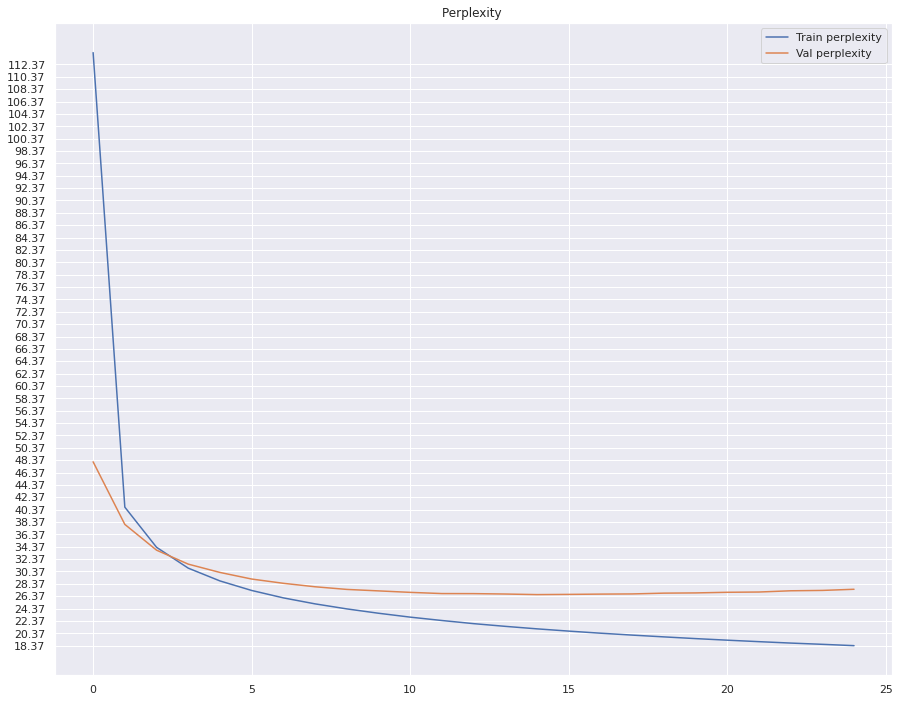

In [67]:
plt.figure(figsize=(15,12))
plt.plot(train_perplexity)
plt.plot(val_perplexity)
plt.yticks(np.arange(min(train_perplexity), max(train_perplexity),2))
plt.legend(['Train perplexity','Val perplexity'])
plt.title('Perplexity ');

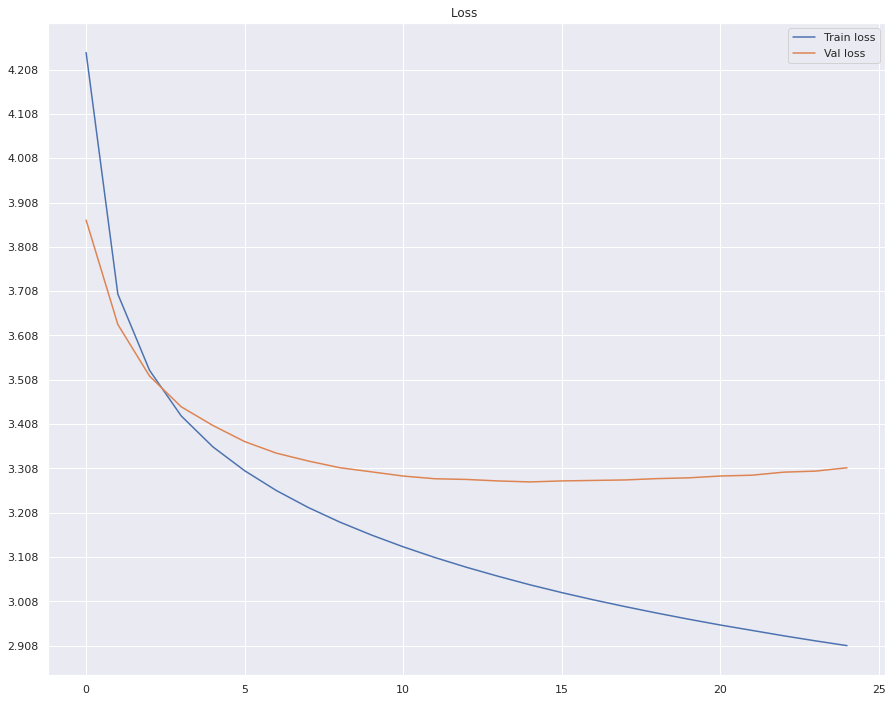

In [68]:
plt.figure(figsize=(15,12))
plt.plot(train_loss)
plt.plot(val_loss)
plt.yticks(np.arange(min(train_loss), max(train_loss),0.1))
plt.legend(['Train loss','Val loss'])
plt.title('Loss ');

# Loading the model

In [36]:
encoder = tf.keras.models.load_model('../models/encoder_date:2021-02-23_fine_tune:False_mode:custom_epoch:11.h5', 
                                     custom_objects={"PartialEmbeddingsUpdate" : PartialEmbeddingsUpdate})
decoder = tf.keras.models.load_model('../models/decoder_date:2021-02-23_fine_tune:False_mode:custom_epoch:11.h5',
                                    custom_objects={"PartialEmbeddingsUpdate" : PartialEmbeddingsUpdate,
                                                   "BahdanauAttention":BahdanauAttention})

In [37]:
max_len_tokens = 20

# Dialogue generation and question answering

In [38]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(i, greedy=True)
    sampled_answer = give_answer(i, greedy=False, top_k=25)
    beam_search_answer = give_answer(i, beam_search=True, beam_size=2)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot sampled answer : {}'.format(sampled_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print(30*'-')


------------------------------
Test replica : hey you!
Bot greedy answer : I am not going to do it !
Bot sampled answer : We just cannot get out to it for . why am this is all what is doing for someone who did my
Bot beam search answer : I am sorry .
------------------------------
------------------------------
Test replica : hello
Bot greedy answer : Hello .
Bot sampled answer : Well you said to make . so long since . he could been gone in my time when my my my
Bot beam search answer : Hi .
------------------------------
------------------------------
Test replica : hi
Bot greedy answer : Hi .
Bot sampled answer : How come from that ? did you hear your hair is up your mother i
Bot beam search answer : Hi .
------------------------------
------------------------------
Test replica : how are you?
Bot greedy answer : I am fine .
Bot sampled answer : Not about about six oclock four ! that makes the time day day and you came to work for all because and with right and see can
Bot beam searc

# Generation of gabberish monologue

In [39]:
inp = input()
iters = 100
print('Start of an everlasting monologue..')
print(30*'-')
c = 0
while iters>=c:
    inp = give_answer(inp, True, greedy=False, beam_search=False,
                               top_k=20, temperature=1, len_output=20)
    print(inp)
    c+=1

hi!
Start of an everlasting monologue..
------------------------------
Hello ? you cannot see the fuck . we could use some more a mile a dozen times like
Okay ! you sure fuck . you can talk in that one i . all the one way to come in
What about all we have a date for him ? where were they there was a couple hundred bucks like and
How is it true possible he can have any money from your wife to kill his mother to you what did
Yeah no that does all our business can find him . the best will be gone . they will want do
What does do have it it for it for for you know i was gonna find the chance ! did he
Yeah what else ? you mean not ? where could happen ? he would not have nothing in an a a
How was did they you do not have no problem i had been talking before that did did i you
Yes but he just knew would have made up here ? we might get that shit back up now it can
They could use your word
I could not say for them at first and
I got that gun you on me on my mouth back ? what ? where are going

# Plotting attention

/home/volodymyr/envs/convbot_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/volodymyr/envs/convbot_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


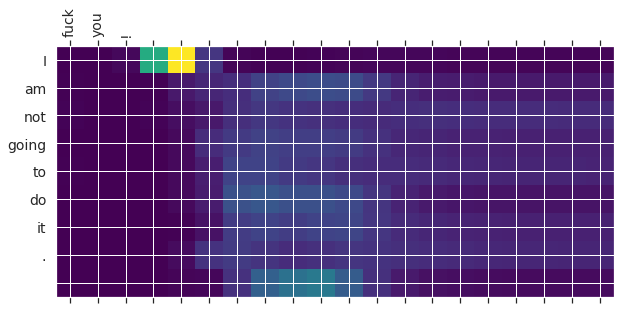

'I am not going to do it .'

In [128]:
replica = 'fuck you !'
give_answer(replica, show_attention=True, greedy=True)

# Interactive usage

In [41]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    answer_beam = give_answer(inp, True, greedy=False, beam_search=True,
                               beam_size=3)
    answer_sampled = give_answer(inp, True, greedy=False, beam_search=False,
                               top_k=3, temperature=1, len_output=20)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(answer_beam))
    print('Sampled answer : {}'.format(answer_sampled))
    print(30*'-')

hello
------------------------------
Replica : hello
Beam answer : Hello .
Sampled answer : I will not have to go .
------------------------------
how are you?
------------------------------
Replica : how are you?
Beam answer : Fine .
Sampled answer : I do not know .
------------------------------
you are under arrest
------------------------------
Replica : you are under arrest
Beam answer : No .
Sampled answer : No ! i am not .
------------------------------
what do you think about marriage?
------------------------------
Replica : what do you think about marriage?
Beam answer : I do not know . it is a good idea .
Sampled answer : What ?
------------------------------


KeyboardInterrupt: Interrupted by user